Methodology:
- Methode 1:
- Feature extraction: (1)via an CNN autoencoder (try another method later) (One for each images? or one on all images, we will try)  (2) Content based image retreival.
- Clustering via a distance based algorithm, return distance. let's try K-means for startig
- Or calculating the SSIM for all images and giving the K-largest SSIM
-  Methode 2:
- Train a similarity DNN

In [1]:
import os 
import pathlib
import matplotlib.pyplot as plt
import cv2
import pandas
import numpy as np

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# loading the resnet50 model
from tensorflow.keras.applications.vgg16 import VGG16
from IPython.display import clear_output

In [2]:
data_path = "./data/geological_similarity/"
preprocessed_data_path = "./data/all"

data_dir = pathlib.Path(data_path)

# Loading & Preprocessing data

In [3]:
data_train = tf.keras.utils.image_dataset_from_directory(data_path,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset = 'training')
data_validation = tf.keras.utils.image_dataset_from_directory(data_path,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset = 'validation')

Found 29998 files belonging to 6 classes.
Using 23999 files for training.
Found 29998 files belonging to 6 classes.
Using 5999 files for validation.


In [4]:
class_names = data_train.class_names
print(class_names)

['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']


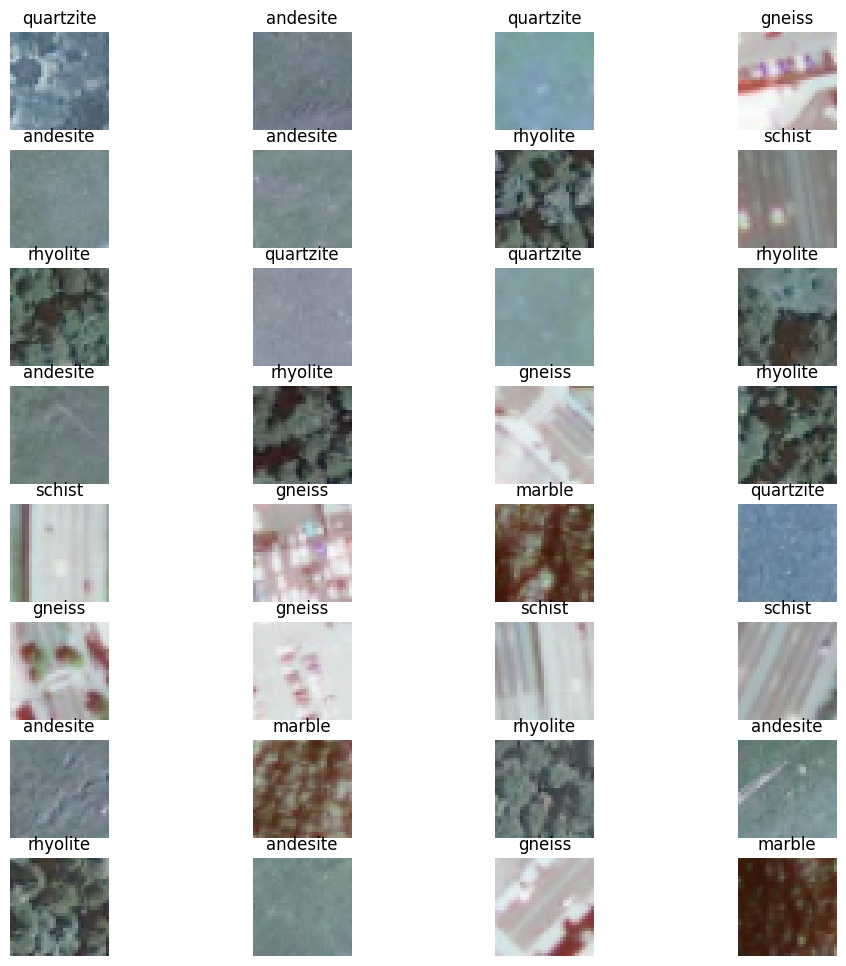

In [5]:
plt.figure(figsize=(12, 12))
for images, labels in data_train.take(1):
    for i in range(32):
        plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [6]:
# Normalizing our images to bring pixels values into [0,1] range
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
data_train = data_train.map(lambda x,y: (normalization_layer(x),y))
data_validation = data_validation.map(lambda x,y: (normalization_layer(x),y))

# Feature Extraction: Training a classifier and getting one of the layers as dimensionality reduction layer

A level of detail for feature extraction from an existing pre-trained model can be chosen. For example, if a new task is quite different from classifying objects in photographs (e.g. different to ImageNet), then perhaps the output of the pre-trained model after the few layers would be appropriate. If a new task is quite similar to the task of classifying objects in photographs, then perhaps the output from layers much deeper in the model can be used, or even the output of the fully connected layer prior to the output layer can be used.

In [7]:
# load model
vgg = VGG16(include_top = False, input_shape = (32, 32, 3))
# summarize the model
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
count = 1
for layer in vgg.layers:
    if count <= 15:
        layer.trainable = False
    count +=1

In [297]:
# add new classifier layers
x = tf.keras.layers.Flatten()(vgg.layers[-1].output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(6, activation='softmax')(x)

# define new model
model = Model(inputs=vgg.inputs, outputs=output)

In [298]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [299]:
model.compile(optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [293]:
def create_scan_sample(dataSet):
    X = []
    y = []
    for image, label in dataSet.as_numpy_iterator():
        for i in range(32):
            X.append(image[i])
            y.append(label[i])
        break
    return np.array(X), np.array(y)
X_train, y_train = create_scan_sample(data_train)
X_val, y_val = create_scan_sample(data_validation)

In [294]:
history = model.fit(X_train, y_train, epochs = 30)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 1.8004 - accuracy: 0.0938
Epoch 2/30
1/1 [==============================] - 1s 541ms/step - loss: 1.6862 - accuracy: 0.2500
Epoch 3/30
1/1 [==============================] - 1s 507ms/step - loss: 1.4660 - accuracy: 0.2500
Epoch 4/30
1/1 [==============================] - 1s 504ms/step - loss: 1.0404 - accuracy: 0.6562
Epoch 5/30
1/1 [==============================] - 1s 516ms/step - loss: 0.8718 - accuracy: 0.6250
Epoch 6/30
1/1 [==============================] - 1s 534ms/step - loss: 1.2128 - accuracy: 0.6562
Epoch 7/30
1/1 [==============================] - 1s 524ms/step - loss: 0.7183 - accuracy: 0.6875
Epoch 8/30
1/1 [==============================] - 1s 503ms/step - loss: 0.4185 - accuracy: 0.8125
Epoch 9/30
1/1 [==============================] - 1s 557ms/step - loss: 0.2862 - accuracy: 0.9062
Epoch 10/30
1/1 [==============================] - 1s 566ms/step - loss: 0.3229 - accuracy: 0.8750
Epoch 11/30
1/1 [=====

In [256]:
loss,accuracy = model.evaluate(X_train,y_train)
print ("Test fraction correct (Accuracy) = {:.2f}".format(accuracy))

1/1 [==============================] - 0s 369ms/step - loss: 0.1192 - accuracy: 0.9375
Test fraction correct (Accuracy) = 0.94


In [300]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [301]:
history = model.fit(data_train, epochs = 100, validation_data = data_validation, callbacks = [EarlyStopping])

Epoch 1/100
750/750 [==============================] - 450s 599ms/step - loss: 0.3058 - accuracy: 0.8855 - val_loss: 0.1653 - val_accuracy: 0.9437
Epoch 2/100
750/750 [==============================] - 468s 623ms/step - loss: 0.1504 - accuracy: 0.9477 - val_loss: 0.1686 - val_accuracy: 0.9488
Epoch 3/100
750/750 [==============================] - 462s 616ms/step - loss: 0.1201 - accuracy: 0.9592 - val_loss: 0.1806 - val_accuracy: 0.9470


In [302]:
model.save("./model/")

INFO:tensorflow:Assets written to: ./model/assets


In [303]:
model.layers[-2]

# Load model 

In [14]:
model = tf.keras.models.load_model('model')

In [17]:
feature_extractor = tf.keras.models.Model(inputs = model.input, outputs = model.layers[-2].output)

# Feature extraction and dimensionality reduction

In [141]:
for image,l in data_train.as_numpy_iterator():
    print(image)
    break

[[[[0.40784317 0.52156866 0.5019608 ]
   [0.3791667  0.48651963 0.4669118 ]
   [0.4291667  0.51887256 0.49926475]
   ...
   [0.40931374 0.48529413 0.479902  ]
   [0.34828433 0.41887257 0.42034316]
   [0.29411766 0.3647059  0.37254903]]

  [[0.41102943 0.5279412  0.49877453]
   [0.38753065 0.49548104 0.4689032 ]
   [0.421201   0.5109069  0.4849265 ]
   ...
   [0.39935663 0.47533703 0.47412688]
   [0.32239586 0.3911918  0.39843753]
   [0.29411766 0.3551471  0.3661765 ]]

  [[0.40637258 0.51862746 0.47647062]
   [0.3994026  0.50428927 0.46531865]
   [0.41616118 0.50502455 0.47049636]
   ...
   [0.39099267 0.46629906 0.47970286]
   [0.35568324 0.41648287 0.43314955]
   [0.304902   0.35833335 0.3781863 ]]

  ...

  [[0.4519608  0.56274515 0.5377451 ]
   [0.45912993 0.5635417  0.54810053]
   [0.46027884 0.5515932  0.5526808 ]
   ...
   [0.33019304 0.3318781  0.33103555]
   [0.30422795 0.3110907  0.30917588]
   [0.37352943 0.38676473 0.38823533]]

  [[0.46200982 0.58431375 0.56617653]
   [0.3

In [64]:
def create_reduced_data(dataSet, feature_extraction_model):
    latent_space = []
    l = []
    for images, labels in dataSet.as_numpy_iterator():
        extracted_features = feature_extractor.predict(images)
        latent_space.append(extracted_features)
        l.append(labels)
    return(np.array(latent_space), np.array(l))

In [65]:
extracted_train_features, labels = create_reduced_data(data_train, feature_extractor)

<ipython-input-64-417470b74762>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return(np.array(latent_space), np.array(l))


In [108]:
extracted_valid_features, labels_valid = create_reduced_data(data_validation, feature_extractor)

<ipython-input-64-417470b74762>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return(np.array(latent_space), np.array(l))


In [91]:
train_data = []
train_labels = []
for batch, label_batch in zip(extracted_train_features, labels):
    for image, label in zip(batch, label_batch):
        train_data.append(image)
        train_labels.append(label)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [109]:
valid_data = []
valid_labels = []
for batch, label_batch in zip(extracted_valid_features, labels_valid):
    for image, label in zip(batch, label_batch):
        valid_data.append(image)
        valid_labels.append(label)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

In [110]:
train_labels_categorical= list(map(lambda x: x.tolist().index(1),train_labels))
valid_labels_categorical = list(map(lambda x: x.tolist().index(1),valid_labels))

In [111]:
pca = PCA(0.99)
pca.fit(train_data)

PCA(n_components=0.99)

In [113]:
pca_space_train = pca.transform(train_data)

In [114]:
pca_space_valid = pca.transform(valid_data)

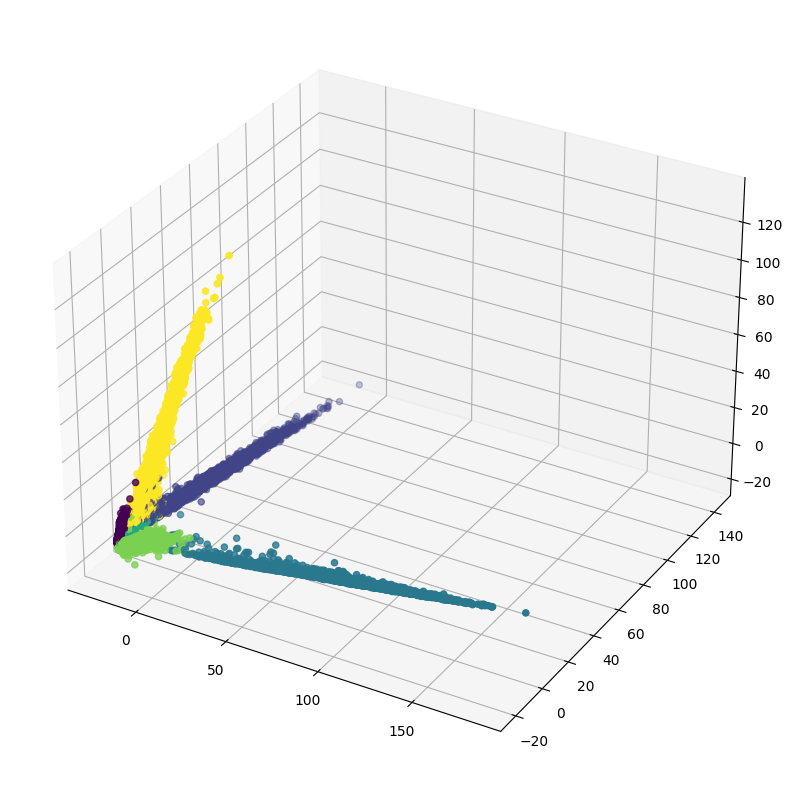

In [119]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_space_train[:,0], pca_space_train[:,1], pca_space_train[:,2], c = train_labels_categorical)
plt.show()

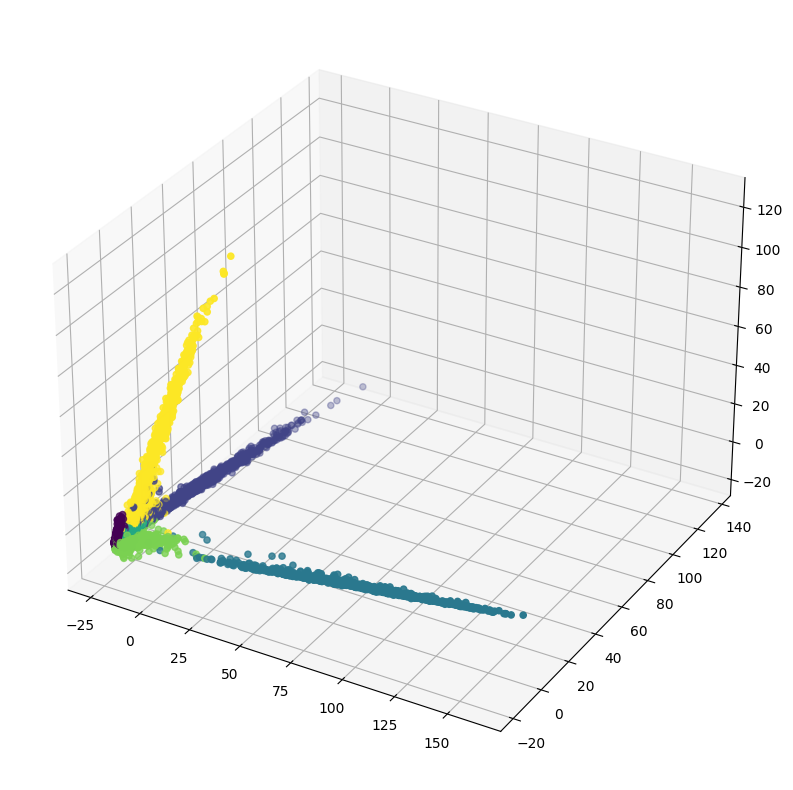

In [120]:
plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_space_valid[:,0], pca_space_valid[:,1], pca_space_valid[:,2], c = valid_labels_categorical)
plt.show()

# Returning the K-most similar images

In [129]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree',).fit(pca_space_train)

In [131]:
distances, indices = nbrs.kneighbors(pca_space_valid[0:1],)
indices

array([[ 5108, 16143,   577,  1353, 18862, 14063, 17943, 21082, 10964,
        11435]], dtype=int64)

In [135]:
kneighborsImages = pca_space_train[indices]

another way to do it: 
is to compute a distance metric X using ssim for all images and use Kneighbors To determine them.